# **PINN - Soft Constraint**

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device selection
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")
device = get_device()
print(f"Using device: {device}")

Mounted at /content/drive
Using device: cuda


In [ ]:
# Parameters
L = 1.0
v = 0.4115
mu = (289 * 17.28 * 1e-5)
EI = (1033610000 * 1e-5) / 17.28**3
p = 0.37
T = L / v

In [ ]:
# Analytical solution
N_modes = 200
# Functions for natural and forcing frequencies
def omega_n(n):
    return (n**2 * np.pi**2 / L**2) * np.sqrt(EI / mu)
def Omega_n(n):
    return n * np.pi * v / L
def S_n(n):
    return Omega_n(n) / omega_n(n)
# Deflection function u(x,t)
def u_xt_true(x, t):
    u_val = 0.0
    for n in range(1, N_modes+1):
        wn = omega_n(n)
        On = Omega_n(n)
        Sn = S_n(n)
        num = np.sin(On*t) - Sn*np.sin(wn*t)
        den = 1 - Sn**2
        if abs(den) < 1e-9:   # avoid division by zero
            den = np.sign(den) * 1e-9
        u_val += (1/n**4) * np.sin(n*np.pi*x/L) * (num/den)
    return (2*p*L**3)/(EI*np.pi**4) * u_val

In [ ]:
# PINN architecture
class PINN(nn.Module):
    """Standard Feedforward Neural Network for PINN"""
    def __init__(self, input_size=2, hidden_size=64, output_size=1, num_layers=7):
        super(PINN, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.Tanh())
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_size, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [ ]:
# Loss functions

# PDE loss
def compute_residual_loss(model, x, t, p, L, v, mu, EI):
    x.requires_grad_(True)
    t.requires_grad_(True)
    residual_points = torch.cat([x, t], dim=1)
    u = model(residual_points)
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]
    u_xxxx = torch.autograd.grad(u_xxx, x, grad_outputs=torch.ones_like(u_xxx), create_graph=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, t, grad_outputs=torch.ones_like(u_t), create_graph=True)[0]
    load_position = (x / L) - ((v / L) * t)
    beta = 0.08
    delta = 1.0 / (beta * torch.sqrt(torch.tensor(np.pi))) * torch.exp(-load_position.pow(2) / (beta**2))
    loss_res = ((mu * u_tt + EI * u_xxxx - p * delta) ** 2).mean()
    return loss_res

# IC loss
def compute_initial_condition_loss(model, x, t):
    initial_points = torch.cat([x, t], dim=1)
    u_initial = model(initial_points)
    loss_initial_u = (u_initial ** 2).mean()
    return loss_initial_u

def compute_initial_condition_loss_lt(model, x, t):
    t.requires_grad_(True)
    initial_points_grad = torch.cat([x, t], dim=1)
    u_initial_grad_l = model(initial_points_grad)
    u_t_initial_l = torch.autograd.grad(u_initial_grad_l, t, grad_outputs=torch.ones_like(u_initial_grad_l), create_graph=True)[0]
    loss_initial_u_t = (u_t_initial_l ** 2).mean()
    return loss_initial_u_t

# BC loss
def compute_boundary_loss_u_r(model, x_0, t_b):
    x_0.requires_grad_(True)
    t_b.requires_grad_(True)
    u_r = model(torch.cat([x_0, t_b], dim=1))
    loss_boundary_u_r = u_r.pow(2).mean()
    return loss_boundary_u_r

def compute_boundary_loss_u_l(model, x_L, t_b):
    x_L.requires_grad_(True)
    t_b.requires_grad_(True)
    u_l = model(torch.cat([x_L, t_b], dim=1))
    loss_boundary_u_l = u_l.pow(2).mean()
    return loss_boundary_u_l

def compute_boundary_loss_uu_r(model, x_0, t_b):
    x_0.requires_grad_(True)
    t_b.requires_grad_(True)
    u_0 = model(torch.cat([x_0, t_b], dim=1))
    u_x_0 = torch.autograd.grad(u_0, x_0, grad_outputs=torch.ones_like(u_0), create_graph=True)[0]
    u_xx_0 = torch.autograd.grad(u_x_0, x_0, grad_outputs=torch.ones_like(u_x_0), create_graph=True)[0]
    loss_boundary_uu_r = u_xx_0.pow(2).mean()
    return loss_boundary_uu_r

def compute_boundary_loss_uu_l(model, x_L, t_b):
    x_L.requires_grad_(True)
    t_b.requires_grad_(True)
    u_L = model(torch.cat([x_L, t_b], dim=1))
    u_x_L = torch.autograd.grad(u_L, x_L, grad_outputs=torch.ones_like(u_L), create_graph=True)[0]
    u_xx_L = torch.autograd.grad(u_x_L, x_L, grad_outputs=torch.ones_like(u_x_L), create_graph=True)[0]
    loss_boundary_uu_l = u_xx_L.pow(2).mean()
    return loss_boundary_uu_l


In [ ]:
# Training function
def train_pinn(model, epochs=30000, lr=1e-3, lambda_pde=0.01, lambda_bc=1.0, lambda_ic=1.0):
    """Trains the PINN using the soft constraint method."""

    # Settings
    N = 10000  # Switch to LBFGS after N iterations
    N_max = 30000  # Maximum iterations
    convergence_threshold = 1e-16  # Convergence criterion

    # Optimizers
    adam_optimizer = optim.Adam(model.parameters(), lr=lr)
    lbfgs_optimizer = optim.LBFGS(model.parameters(), lr=1e-5, max_iter=100, tolerance_grad=1e-5, tolerance_change=1e-9, history_size=50)

    # Data points
    torch.manual_seed(2000)
    np.random.seed(2000)
    # PDE residual points
    x_res = torch.rand(2500, 1).to(device) * L
    t_res = torch.rand(2500, 1).to(device) * T
    # Boundary points
    t_boundary = torch.rand(1000, 1).to(device) * T
    x_boundary_0 = torch.zeros_like(t_boundary).to(device)
    x_boundary_L = L * torch.ones_like(t_boundary).to(device)
    # Initial condition points
    x_initial = torch.rand(1000, 1).to(device) * L
    t_initial = torch.zeros_like(x_initial).to(device)

    print(f"\n--- Training PINN (epochs={epochs}) ---")
    history = {'total': [], 'pde': [], 'bc': [], 'ic': []}

    prev_loss = float('inf')
    pbar = tqdm(range(1, N_max + 1), desc="Training PINN", ncols=120)
    for j in pbar:

        # Define closure for LBFGS
        def closure():
            lbfgs_optimizer.zero_grad()
            loss_pde = compute_residual_loss(model, x_res, t_res, p, L, v, mu, EI)
            loss_boundary_u_r = compute_boundary_loss_u_r(model, x_boundary_0, t_boundary)
            loss_boundary_u_l = compute_boundary_loss_u_l(model, x_boundary_L, t_boundary)
            loss_boundary_uu_r = compute_boundary_loss_uu_r(model, x_boundary_0, t_boundary)
            loss_boundary_uu_l = compute_boundary_loss_uu_l(model, x_boundary_L, t_boundary)
            loss_bc = loss_boundary_u_r + loss_boundary_u_l + loss_boundary_uu_r + loss_boundary_uu_l
            loss_initial = compute_initial_condition_loss(model, x_initial, t_initial)
            loss_initial_t = compute_initial_condition_loss_lt(model, x_initial, t_initial)
            loss_ic = loss_initial + loss_initial_t
            total_loss = (lambda_pde * loss_pde + lambda_bc * loss_bc + lambda_ic * loss_ic)
            total_loss.backward()
            return total_loss

        # Optimizer step
        if j <= N:
            # Use Adam
            adam_optimizer.zero_grad()
            loss_pde = compute_residual_loss(model, x_res, t_res, p, L, v, mu, EI)
            loss_boundary_u_r = compute_boundary_loss_u_r(model, x_boundary_0, t_boundary)
            loss_boundary_u_l = compute_boundary_loss_u_l(model, x_boundary_L, t_boundary)
            loss_boundary_uu_r = compute_boundary_loss_uu_r(model, x_boundary_0, t_boundary)
            loss_boundary_uu_l = compute_boundary_loss_uu_l(model, x_boundary_L, t_boundary)
            loss_bc = loss_boundary_u_r + loss_boundary_u_l + loss_boundary_uu_r + loss_boundary_uu_l
            loss_initial = compute_initial_condition_loss(model, x_initial, t_initial)
            loss_initial_t = compute_initial_condition_loss_lt(model, x_initial, t_initial)
            loss_ic = loss_initial + loss_initial_t
            total_loss = (lambda_pde * loss_pde + lambda_bc * loss_bc + lambda_ic * loss_ic)
            total_loss.backward()
            adam_optimizer.step()
        else:
            # Use LBFGS
            total_loss = lbfgs_optimizer.step(closure)

        # Convergence check
        loss_change = prev_loss - total_loss.item()
        if abs(loss_change) < convergence_threshold:
            print(f"\nConverged after {j} iterations.")
            break
        prev_loss = total_loss.item()

        # Logging
        loss_pde = compute_residual_loss(model, x_res, t_res, p, L, v, mu, EI)
        loss_boundary_u_r = compute_boundary_loss_u_r(model, x_boundary_0, t_boundary)
        loss_boundary_u_l = compute_boundary_loss_u_l(model, x_boundary_L, t_boundary)
        loss_boundary_uu_r = compute_boundary_loss_uu_r(model, x_boundary_0, t_boundary)
        loss_boundary_uu_l = compute_boundary_loss_uu_l(model, x_boundary_L, t_boundary)
        loss_bc = loss_boundary_u_r + loss_boundary_u_l + loss_boundary_uu_r + loss_boundary_uu_l
        loss_initial = compute_initial_condition_loss(model, x_initial, t_initial)
        loss_initial_t = compute_initial_condition_loss_lt(model, x_initial, t_initial)
        loss_ic = loss_initial + loss_initial_t

        # Save history
        history['total'].append(total_loss.item())
        history['pde'].append(loss_pde.item())
        history['bc'].append(loss_bc.item())
        history['ic'].append(loss_ic.item())

        pbar.set_postfix({
            'Total': f'{total_loss.item():.2e}',
            'PDE': f'{loss_pde.item():.2e}',
            'BC': f'{loss_bc.item():.2e}',
            'IC': f'{loss_ic.item():.2e}'
        })

    pbar.close()
    return model, history

# Instantiate and train the model
pinn_model = PINN().to(device)
pinn_model_trained, history = train_pinn(pinn_model)


--- Training PINN (epochs=30000) ---


Training PINN:  48%|██▊   | 14371/30000 [25:53<28:09,  9.25it/s, Total=3.58e-06, PDE=2.75e-04, BC=4.05e-07, IC=4.23e-07]


Converged after 14372 iterations.


In [ ]:
# Save model
PATH = "/content/drive/My Drive/SciML/SciML Project/SciML_project_soft.pth"
torch.save({
    'model_state_dict': pinn_model.state_dict(),
}, PATH)

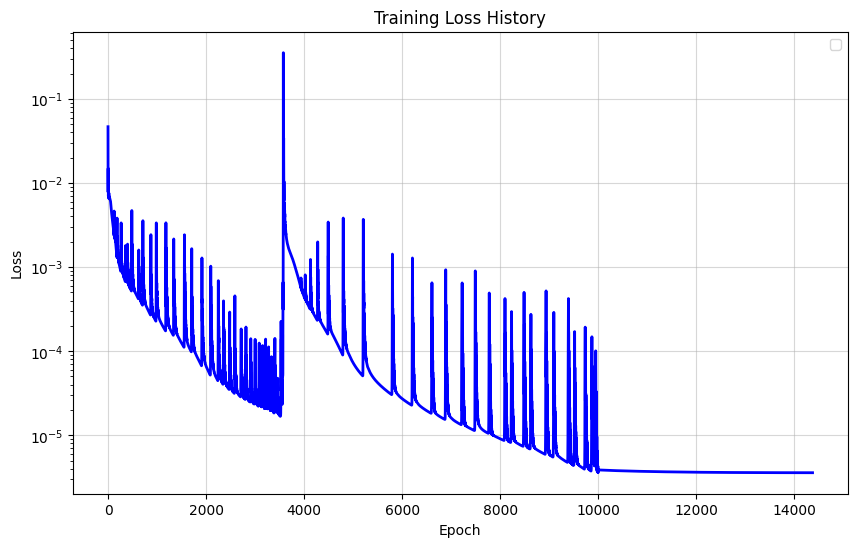

In [ ]:
# Plot loss history
plt.figure(figsize=(10,6))
plt.semilogy(history['total'], color='blue', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

t = 0.61 sec : RMSE = 0.164 mm
t = 1.22 sec : RMSE = 0.328 mm
t = 1.82 sec : RMSE = 0.163 mm


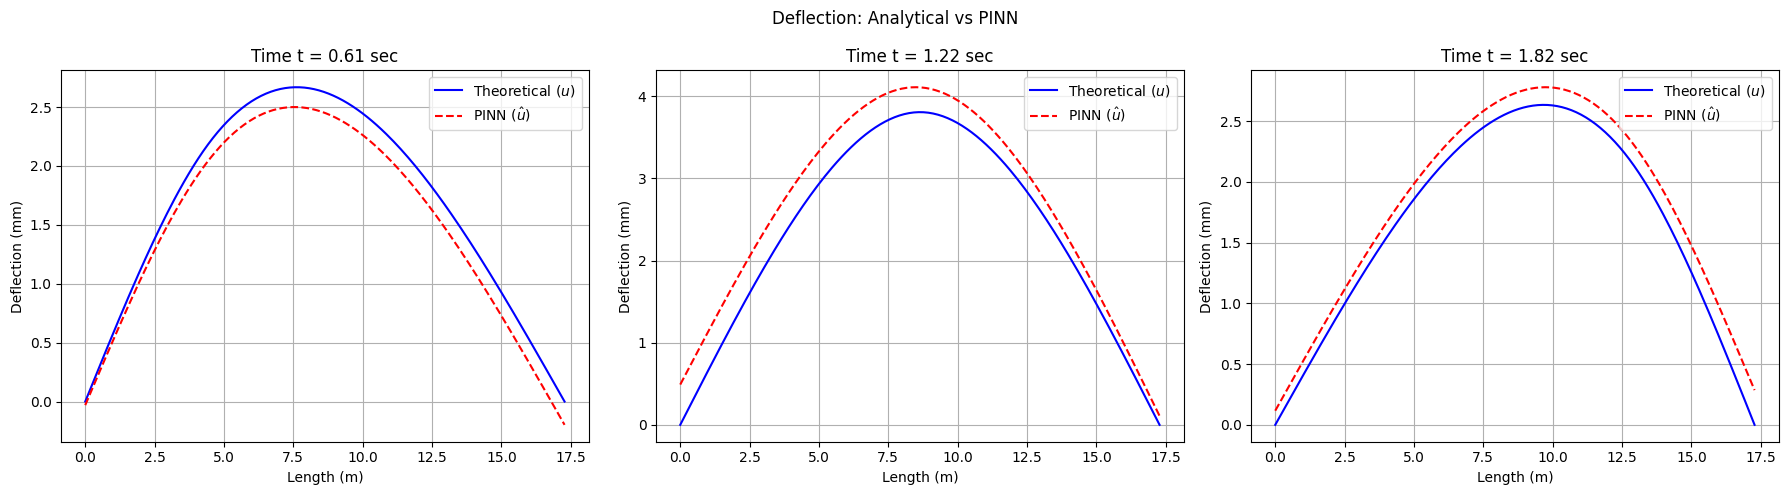

In [ ]:
# Generate test points for plotting
t_values = [0.25*T, 0.5*T, 0.75*T]
x_test = np.linspace(0, L, 200)
x_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1).to(device)

# Plot PINN vs Analytical Solution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, t_val in enumerate(t_values):
    # Create t_tensor for current time
    t_tensor = torch.full_like(x_tensor, t_val).to(device)

    # Analytical solution
    u_true = np.array([u_xt_true(x, t_val) for x in x_test])

    # PINN prediction
    with torch.no_grad():
        u_pred = pinn_model(torch.cat([x_tensor, t_tensor], dim=1)).cpu().numpy()

    # RMSE
    rmse = np.sqrt(np.mean((u_true.flatten() - u_pred.flatten())**2))
    print(f"t = {t_val:.2f} sec : RMSE = {rmse*1000:.3f} mm")

    # Plot
    axes[i].plot(x_test*17.28, u_true*1000, 'b-', label='Theoretical ($u$)')
    axes[i].plot(x_test*17.28, u_pred*1000, 'r--', label='PINN ($\hat{u}$)')
    axes[i].set_xlabel('Length (m)')
    axes[i].set_ylabel('Deflection (mm)')
    axes[i].set_title(f'Time t = {t_val:.2f} sec')
    axes[i].grid(True)
    axes[i].legend(loc='upper right')

plt.suptitle('Deflection: Analytical vs PINN')
plt.tight_layout()
plt.show()

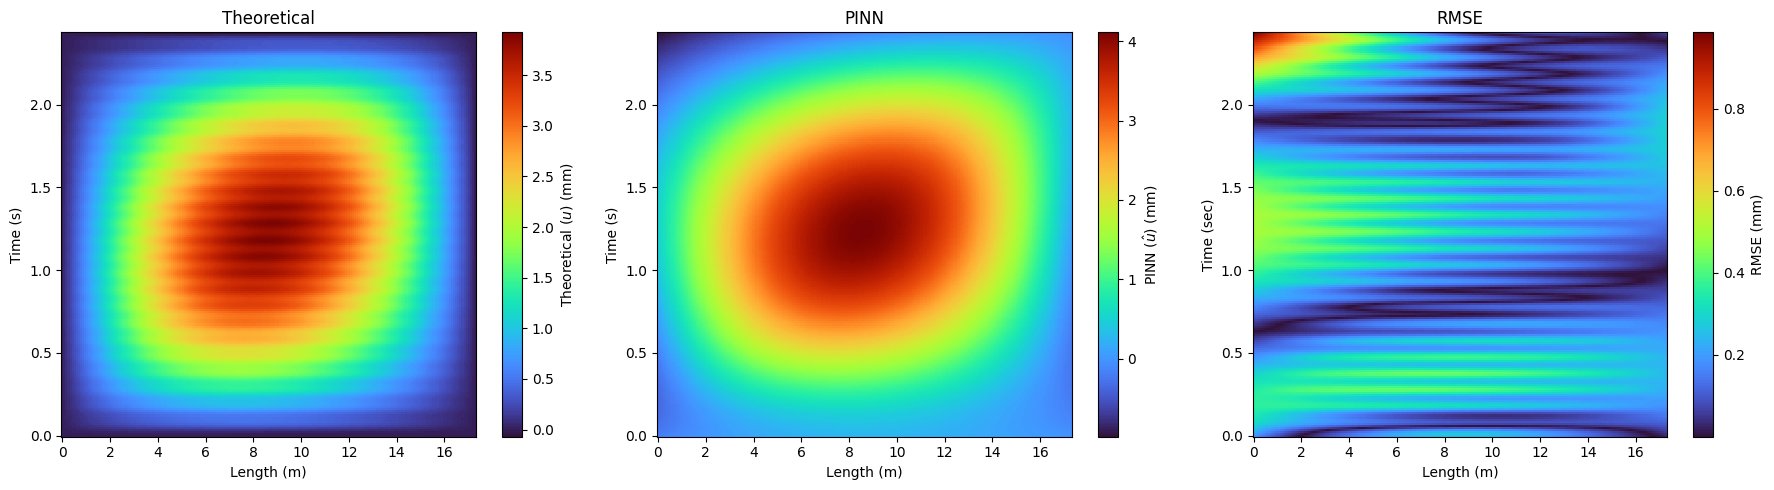

In [ ]:
# Plot the heatmap
x_plot = torch.linspace(0, L, 200).unsqueeze(1).to(device)
t_plot = torch.linspace(0, T, 200).unsqueeze(1).to(device)
X, T_grid = torch.meshgrid(x_plot.squeeze(), t_plot.squeeze(), indexing='ij')
XT = torch.cat([X.reshape(-1,1), T_grid.reshape(-1,1)], dim=1).to(device)

# PINN heatmap
with torch.no_grad():
    u_prediction = pinn_model(XT).cpu().numpy().reshape(200,200)

# Analytical heatmap
u_analytical = np.zeros((200,200))
for i, x in enumerate(x_plot.cpu().numpy().squeeze()):
    for j, t in enumerate(t_plot.cpu().numpy().squeeze()):
        u_analytical[i,j] = u_xt_true(x, t)

# RMSE
rmse = np.sqrt((u_analytical - u_prediction)**2)

# Plot side by side
fig, axes = plt.subplots(1, 3, figsize=(18,5))

# Analytical
im0 = axes[0].pcolormesh(X.cpu()*17.28, T_grid.cpu(), u_analytical*1000, shading='auto', cmap='turbo')
axes[0].set_title('Theoretical')
axes[0].set_xlabel('Length (m)')
axes[0].set_ylabel('Time (s)')
fig.colorbar(im0, ax=axes[0], label=r'Theoretical ($u$) (mm)')

# PINN
im1 = axes[1].pcolormesh(X.cpu()*17.28, T_grid.cpu(), u_prediction*1000, shading='auto', cmap='turbo')
axes[1].set_title('PINN')
axes[1].set_xlabel('Length (m)')
axes[1].set_ylabel('Time (s)')
fig.colorbar(im1, ax=axes[1], label=r'PINN ($\hat{u}$) (mm)')

# RMSE
im2 = axes[2].pcolormesh(X.cpu()*17.28, T_grid.cpu(), rmse*1000, shading='auto', cmap='turbo')
axes[2].set_title('RMSE')
axes[2].set_xlabel('Length (m)')
axes[2].set_ylabel('Time (sec)')
fig.colorbar(im2, ax=axes[2], label='RMSE (mm)')

plt.tight_layout()
plt.show()

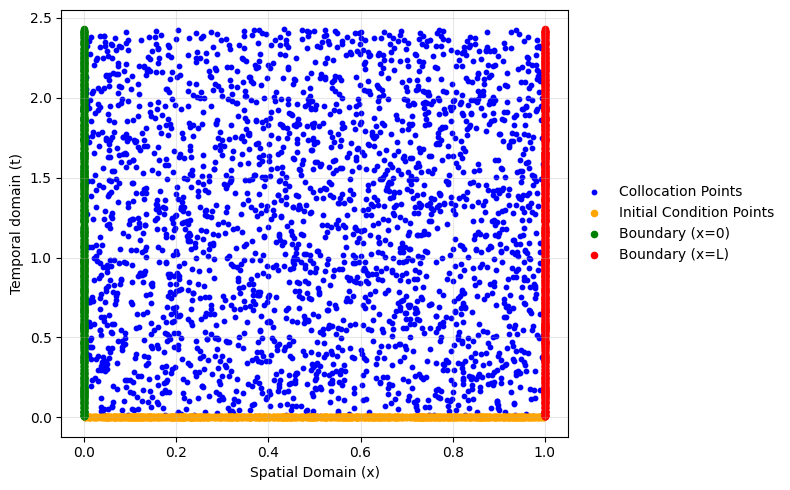

In [ ]:
# Plot points in (x, t) space for training PINNs

# Data points
torch.manual_seed(2000)
np.random.seed(2000)
# PDE residual points
x_res = torch.rand(2500, 1).to(device) * L
t_res = torch.rand(2500, 1).to(device) * T
# Boundary points
t_boundary = torch.rand(1000, 1).to(device) * T
x_boundary_0 = torch.zeros_like(t_boundary).to(device)
x_boundary_L = L * torch.ones_like(t_boundary).to(device)
# Initial condition points
x_initial = torch.rand(1000, 1).to(device) * L
t_initial = torch.zeros_like(x_initial).to(device)

plt.figure(figsize=(8, 5))

plt.scatter(x_res.detach().cpu().numpy(),
            t_res.detach().cpu().numpy(),
            color='blue', s=10, label='Collocation Points')

plt.scatter(x_initial.detach().cpu().numpy(),
            t_initial.detach().cpu().numpy(),
            color='orange', s=20, label='Initial Condition Points')

plt.scatter(x_boundary_0.detach().cpu().numpy(),
            t_boundary.detach().cpu().numpy(),
            color='green', s=20, label='Boundary (x=0)')

plt.scatter(x_boundary_L.detach().cpu().numpy(),
            t_boundary.detach().cpu().numpy(),
            color='red', s=20, label='Boundary (x=L)')

plt.xlabel('Spatial Domain (x)')
plt.ylabel('Temporal domain (t)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()